In [2]:
# If one doesn't have biopython installed, it can be uploaded by following command
!pip3 install biopython

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [0]:
import pandas as pd
from Bio import SeqIO
import numpy as np
import gc
from scipy import sparse
from pandas import read_csv
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Upload data and models

In [8]:
from keras import backend as K
from keras.models import load_model

batch_size = 128

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

Using TensorFlow backend.


In [0]:
# Uploads and returns list of names of chromosomes
def GetChromeNames():
  with open('chrome_names.npy', 'rb') as f:
    return np.load(f)

# Uploads and returns indexes for each fold 
def GetFoldsIndexes():
  with open('folds_indexes.npy', 'rb') as f:
    return np.load(f)

# Uploads and returns sequenced gene infomation in np.array type
def GetGeneNp():
  records = list(SeqIO.parse("data/dm6.fa", "fasta"))
  gene_np = {}
  for record in records:
    if record.name in chrome_names:
      gene_np[record.name] = np.array(record.seq)
  return gene_np

# Uploads and returns deep learned models for each fold
def GetModels():
  models = []
  for i in range(5):
    model = load_model('folds/model_{i}'.format(i=i),  
                       custom_objects={'root_mean_squared_error': root_mean_squared_error})
    models.append(model)
  return models

In [0]:
# Gets all data required data
chrome_names = GetChromeNames()
folds_indexes = GetFoldsIndexes()
gene_np = GetGeneNp()
models = GetModels()
annotation = {}
for name in chrome_names:
  annotation[name] = np.zeros(len(gene_np[name]))

# Annotation

In [0]:
# Returns index in general list for specific chromosome and place in it
def GetIndexByPlace(chr_n, i, seg_size=1000):
  answer = 0
  for name in chrome_names:
    if (name == chr_n):
      break
    answer += len(gene_np[name]) // seg_size
  if (len(gene_np[chr_n]) / seg_size == i // seg_size):
    return -1
  return answer + (i + seg_size - 1) // seg_size

# Returns chromosome and place in it by index in general list
def GetPlaceByIndex(index, chrome_names, seg_size=1000):
  i = index
  for name in chrome_names:
    if (i >= len(gene_np[name]) // seg_size):
      i -= len(gene_np[name]) // seg_size
    else:
       return [name, i] 

# Returns model for specific  in it by index in general list
def GetModelByIndex(index):
  for i in range(5):
    if (index in folds_indexes[i]):
      return models[i]

# Returns prediction of specific model for given data
def PredictProba(X_train, model, seg_size=1000):
  return model.predict_proba(X_train)

# Puts predictions to answer array
def PutResult(probs, indexes, chrome_names,  answer, seg_size=1000):
  for i in range(len(probs)):
    index = indexes[i]
    name, pos = GetPlaceByIndex(index, chrome_names, seg_size)
    answer[name][pos * seg_size : (pos + 1) * seg_size] = probs[i]

In [0]:
# Predicts and puts result for each fold
for i in range(5):
  model = models[i]
  X_train = np.array(sparse.csr_matrix.todense(sparse.load_npz("folds/folds_feat_{i}.npz".format(i=i)))).reshape(-1, 1000, 5)
  probs = PredictProba(X_train, model)
  PutResult(probs, folds_indexes[i], chrome_names, annotation)

# Save results

In [0]:
# Saves results for each chromosome in .npi format.
for name in chrome_names:
  with open('annotation/{name}.npy'.format(name=name), 'wb') as f:
    np.save(f, np.array(annotation[name]))

# Examples

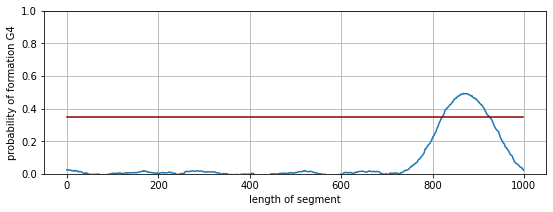

In [0]:
plt.figure(figsize=(9, 3))
plt.plot(range(1000), annotation['chr2L'][28000:29000])
plt.xlabel('length of segment')
plt.ylabel('probability of formation G4')
plt.grid(True)
plt.ylim([0, 1])
plt.plot(range(1000), [0.35] * 1000, color='darkred')
plt.show()

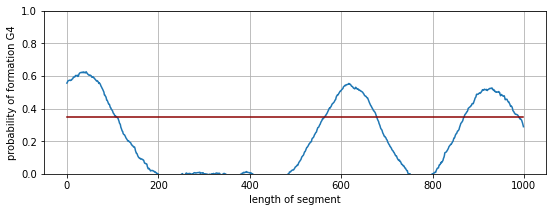

In [0]:
plt.figure(figsize=(9, 3))
plt.plot(range(1000), annotation['chr2L'][846000:847000])
plt.xlabel('length of segment')
plt.ylabel('probability of formation G4')
plt.grid(True)
plt.plot(range(1000), [0.35] * 1000, color='darkred')
plt.ylim([0, 1])
plt.show()

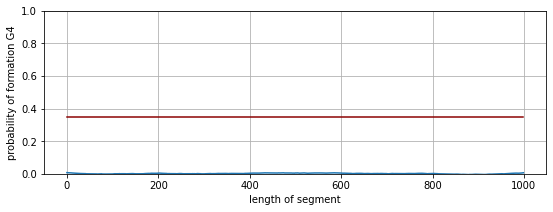

In [0]:
plt.figure(figsize=(9, 3))
plt.plot(range(1000), annotation['chrX'][2000:3000])
plt.xlabel('length of segment')
plt.ylabel('probability of formation G4')
plt.grid(True)
plt.plot(range(1000), [0.35] * 1000, color='darkred')
plt.ylim([0, 1])
plt.show()

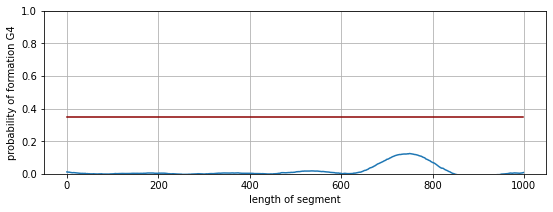

In [0]:
plt.figure(figsize=(9, 3))
plt.plot(range(1000), annotation['chr2L'][7000:8000])
plt.xlabel('length of segment')
plt.ylabel('probability of formation G4')
plt.grid(True)
plt.plot(range(1000), [0.35] * 1000, color='darkred')
plt.ylim([0, 1])
plt.show()